In [1]:
%matplotlib inline
import pandas as pd
import os
from sklearn import datasets
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

from utils import * 
from causalDataframe import *
from causal_discovery.ncda import * 
from baselines.correlations import * 
from data_generation.randomDataframe import *
from data_generation.relatedDataframe import * 
from data_generation.evaluation.kde import *
from data_generation.evaluation.lof import *
from sdv.tabular import CTGAN
from sdv.tabular import TVAE

In [2]:
path = '/Users/martina/Desktop/'

# DATASETS

**1# Option**: From sklearn

In [ ]:
"""
A possible Ground Truth 

['bmi' --> 'si', 'bmi' --> 'bp', 'si' --> 'bp']

"""

diabetes = datasets.load_diabetes()
dataframe = diabetes['data'][:, [0, 1, 2, 3, 4]]
data = pd.DataFrame(dataframe, columns=['age', 'sex', 'bmi', 'bp', 'si'])
data.head()

**2# Option**: From project folder

In [3]:
"""
Avaiable datasets 

Abalone            Ground Truth: ['Rings' --> 'Length']
Old Faithful       Ground Truth: ['Time Interval' --> 'Duration']
Climate            Ground Truth: ['Altitude' --> 'Temperature']
Undata             Ground Truth: ['Female Age' <-- 'Latitude']
Synthetic          Ground Truth: ['w' --> 'x', 'w' --> 'y', 'x' --> 'z', 'y' --> z]

"""
directory = os.path.abspath('')
file_path = os.path.join(os.path.dirname(directory), 'GENCDA', 'datasets', 'synthetic.csv')
data = pd.read_csv(file_path)

**3# Option**: Create a new dataframe from a random DAG

In [ ]:
# Create a new graph with 5 nodes and 2 edges
# This function returns also a json file. It contains all the information about the dag.
graph = randomDag(path, 4, 2)
print(f'Nodes: {graph.nodes} \nEdges: {graph.edges}')
n_samples = 1500

# Instantiate main class with the number of samples and the dag
d = CausalDataFrame(n_samples, graph)

In [ ]:
# Generate a dataset based on the graph structure
d.generate_data()
# Get as a dataframe
data = d.dataframe
# Save the new dataframe
data.to_csv(os.path.join(path, 'dataset.csv'), index=False)
# Show the generated random dag
d.show_graph()

data.head()


**4# Option**: Create a new dataframe from a known graph

In [ ]:
edges = [('0', '2'), ('1', '2'), ('2', '7'), ('1', '4'), ('4', '8')]
isolated_nodes = ['3', '5', '6']
n_samples = 1500

# Instantiate main class with the number of samples and the dag
d = CausalDataFrame(n_samples, edges, isolated_nodes)
# Generate a dataset based on the graph structure
d.generate_data()

In [ ]:
# Get as a dataframe
data = d.dataframe
# Save the new dataframe
data.to_csv(os.path.join(path, 'dataset.csv'), index=False)
# Show the generated random dag
d.show_graph()

data.head()

## DAG DESCRIBING THE CAUSAL STRUCTURE OF THE DATA

**1# Option**: Based on a known ground truth

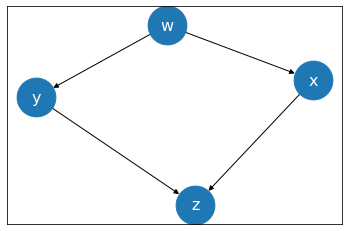

In [4]:
"""
Example: Synthetic Dataset

"""
graph = nx.DiGraph()
graph.add_nodes_from(['w', 'y', 'x', 'z'])
graph.add_edges_from([('w', 'x'), ('w', 'y'), ('x', 'z'), ('y', 'z')])
nx.draw_networkx(graph, node_size=1500, font_color='w', font_size=16)
plt.show()

**2# Option**: From a random graph

In [ ]:
graph = randomDag(path, 6, 4)
nx.draw_networkx(graph, node_size=1500, font_color='w', font_size=16)
plt.show()

# NCDA - Nonlinear Causal Discovery with Apriori

In [5]:
# Instantiate main class
ncda = NCDApriori(data)

In [6]:
# Fit Apriori 

"""
Since our method works on continuos dataset, we discretize our dataframe to apply the pattern mining algorithm. 

"""

itemsets = ncda.fitApriori(target='m', zmax=3, nbins=4, strategy='quantile', support=5)

In [7]:
print(f'Maximal itemsets found by Apriori: \n\n{itemsets}')

Maximal itemsets found by Apriori: 

[('z', 'x', 'y'), ('x', 'w', 'y'), ('z', 'x', 'w'), ('z', 'w', 'y')]


In [8]:
"""
Evaluation of the number of relations found comparing frequent items found by apriori and the dag. 
In this case, we verify relations on an undirect acyclic graph 
since we want to know if apriori detects any relationship. Then, edges directions are not relevant.

"""

ncda.evaluateRelations(graph)

{'precision': 0.6666666666666666,
 'recall': 1.0,
 'accuracy': 0.6666666666666666,
 'f1': 0.8}

In [9]:
# Fit Causal Discovery Algorithm implemented by Hoyer et al.

causal_relations = ncda.fitNCD(itemsets, alpha=0.001, sorting=np.mean, train_size=0.7, standardization=True)
causal_relations

[('w', 'z'), ('y', 'z')]

In [10]:
"""
Evaluation of the number of relations found comparing causal relationship found by NCD and the ground truth. 
In this case, we verify relations on an direct acyclic graph.
""" 

# We have to transform dag edges as strings
edges = [(str(source), str(destination)) for source, destination in graph.edges]

precision, recall, accuracy, f1 = evaluate(causal_relations, edges, graph)
print(f'Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}\nF1: {f1}')

Precision: 0.5
Recall: 0.25
Accuracy: 0.6666666666666666
F1: 0.3333333333333333


# CAUSAL DISCOVERY BASELINES: CORRELATIONS 

Possibile correlation coefficients to check: Pearson, Spearman, Hoeffding

In [11]:
# main class
corr = Correlation()

Compute test statistic **between two variables**

In [ ]:
r, p_value = corr.pearson(data.iloc[:, 0], data.iloc[:, 1])
r, p_value

Compute **pairwise correlation of columns**

In [12]:
new_df = corr.pairwise(data, pearsonr)
columns, confusion_matrix = corr.evaluate(new_df, graph)
print(f'List of indices of column pairs that are correlated: {columns}')

List of indices of column pairs that are correlated: ['x-y', 'y-z']


In [13]:
"""
Evaluation of the number of relations found comparing relations found by correlation metric and the ground truth. 
In this case, we verify relations on an undirect acyclic graph.

"""
precision, recall, accuracy, f1 = evaluation_measures(confusion_matrix)
print(f'Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}\nF1: {f1}')

Precision: 0.5
Recall: 0.25
Accuracy: 0.3333333333333333
F1: 0.3333333333333333


# SYNTHETIC DATA GENERATOR

A synthetic dataset generator for tabular data that is able to discover the nonlinear causalities 
among the variables and use them at generation time. 

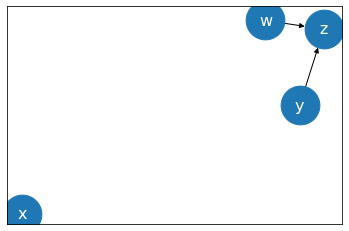

In [14]:
# Generate a DAG from causal relationships founded by NCDA
dag_ncda = nx.to_networkx_graph(causal_relations, create_using=nx.DiGraph)

# Add isolated nodes. We select them from dataset columns
dag_nodes = list(data.columns)
dag_ncda.add_nodes_from(dag_nodes)

nx.draw_networkx(dag_ncda, node_size=1500, font_color='w', font_size=16)
plt.show()

In [15]:
# Instantiate main class
generator = RelatedDataframe(data, dag_ncda)

# Generate new data based on ground truth dag 
gencda_data = generator.generate_data()

# Show new dataframe 
gencda_data.head()

,w,x,y,z
0,-5.076428,2.449930,8.803324,-1.479276
1,1.998780,4.655677,9.075153,3.451354
2,-5.162005,7.205788,8.460113,-0.234688
3,0.578747,3.168349,15.496952,2.862477
4,2.877647,1.385685,15.136131,1.395770


# SYNTHETIC DATA GENERATION BASELINES

1# Baseline: **RANDOM GENERATION**

In [16]:
random_data = randomDataframe(data)

2# Baseline: **CTGAN**

In [17]:
"""
From Synthetic Data Vault Library (SDV)
https://sdv.dev/SDV/api_reference/tabular/api/sdv.tabular.ctgan.CTGAN.html

"""
# Instantiate main class
model = CTGAN()

# Fit CTGAN
model.fit(data)

# Save model
model.save(os.path.join(path, 'ctgan_model.pkl'))

# Generate new data
ctgan_data = model.sample(len(data))

# Save new dataframe 
ctgan_data.to_csv(os.path.join(path, 'ctgan_dataset.csv'), index=False)

3# Baseline: **TVAE**

In [18]:
"""
From SDV Library 
https://sdv.dev/SDV/api_reference/tabular/api/sdv.tabular.ctgan.TVAE.html

"""
# To apply tvae, the svd library requires columns names as strings 
if data.columns.dtype != 'str':
    data.columns = data.columns.astype(str)

# Instantiate main class
model = TVAE()

# Fit TVAE
model.fit(data)

# Save model
model.save(os.path.join(path, 'tvae_model.pkl'))

# Generate new data
tvae_data = model.sample(len(data))

# Save new dataframe 
tvae_data.to_csv(os.path.join(path, 'tvae_dataset.csv'), index=False)

# EVALUATION MEASURE

1) Compute SSE, RMSE using KERNEL DENSITY ESTIMATION

In [19]:
print(f'GENDATA {get_statistics(data, gencda_data)}')

print('\n')
print(f'RANDOM {get_statistics(data, random_data)}')

print('\n')
print(f'CTGAN {get_statistics(data, ctgan_data)}')

print('\n')
print(f'TVAE {get_statistics(data, tvae_data)}')


GENDATA {'rmse': {'mean': 0.0670218448689703}, 'sse': {'mean': 0.5439603342645675}}


RANDOM {'rmse': {'mean': 0.04557796751574669}, 'sse': {'mean': 0.22303436749280944}}


CTGAN {'rmse': {'mean': 0.05414617564240876}, 'sse': {'mean': 0.32723518441740584}}


TVAE {'rmse': {'mean': 0.03776225574472408}, 'sse': {'mean': 0.1555485838498466}}


2) Local Outlier Factor

In [20]:
print(f'GENDATA {lof(data, gencda_data, n_neighbors=50)}')

print('\n')
print(f'RANDOM {lof(data, random_data, n_neighbors=50)}')

print('\n')
print(f'CTGAN {lof(data, ctgan_data, n_neighbors=50)}')

print('\n')
print(f'TVAE {lof(data, tvae_data, n_neighbors=50)}')


GENDATA {'n_error_test': 970, 'stats': {'mean': -2.708328690216374, 'max': 0.5373817013837211, 'min': -12.763842204073244, 'std': 1.8697225206779295, 'median': -2.4693080717168234}}


RANDOM {'n_error_test': 547, 'stats': {'mean': -0.1547701802750817, 'max': 0.5355414932504702, 'min': -2.136372901310174, 'std': 0.529723039078439, 'median': -0.06968485509552991}}


CTGAN {'n_error_test': 521, 'stats': {'mean': -0.17314878220233954, 'max': 0.5380529254826253, 'min': -2.7488555344968395, 'std': 0.5819161339002178, 'median': -0.024218910813804673}}


TVAE {'n_error_test': 93, 'stats': {'mean': 0.32748071324726025, 'max': 0.5457223609377649, 'min': -1.265010581088962, 'std': 0.24063022587639216, 'median': 0.419350861167221}}


# PLOT 

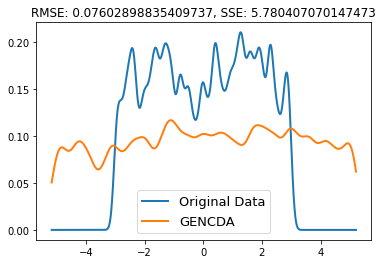

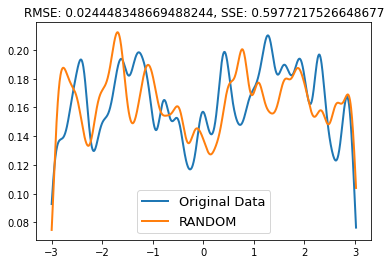

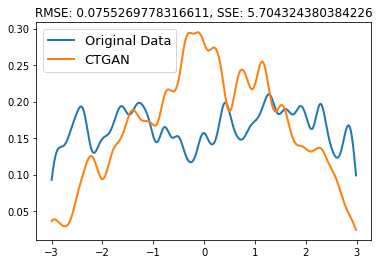

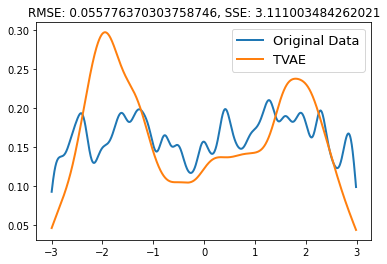

In [21]:
# Set index of column to plot
index = 0

datasets = [gencda_data, random_data, ctgan_data, tvae_data]
names = ['GENCDA', 'RANDOM', 'CTGAN', 'TVAE']

for dataset, name in zip(datasets, names):
    plotKDE(data.iloc[:, index], dataset.iloc[:, index], label1='Original Data', label2=name)
plt.show()

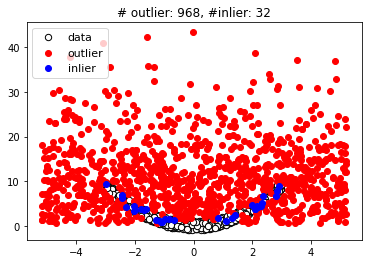

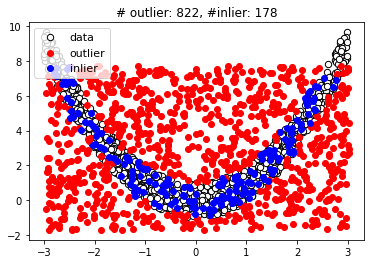

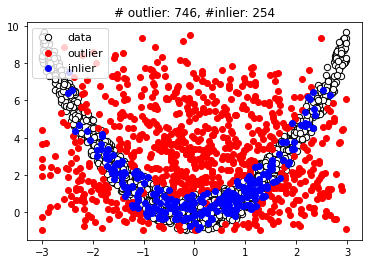

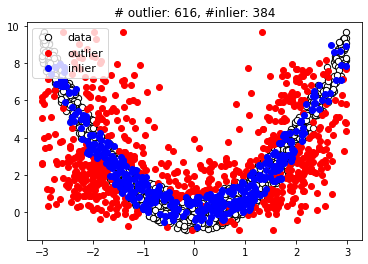

In [22]:
# Set index of column to plot
index = [0, 1]

datasets = [gencda_data, random_data, ctgan_data, tvae_data]
names = ['GENCDA', 'RANDOM', 'CTGAN', 'TVAE']

for dataset in [gencda_data, random_data, ctgan_data, tvae_data]:
    plotLOF(data.iloc[:, index], dataset.iloc[:, index])
    plt.show()
